In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)
data_path = os.path.join(project_root, "data\\raw")
file_path = os.path.join(data_path, "Desempleo.xls")

FIG_PATH = os.path.join(project_root, "results", "figures")
os.makedirs(FIG_PATH, exist_ok=True)

from utils import table_kpss, table_adf, arma_model_selection, significant_params, forecast_with_ci, calculate_rmse
from plots import plot_acf_sample, plot_pacf_sample, plot_acf_theoretical, plot_pacf_theoretical, arma_forecast_plot, plot_residuals, plot_acf_pacf_residuals, residuals_normality_test, arma_forecast_plot2

np.random.seed(4242)

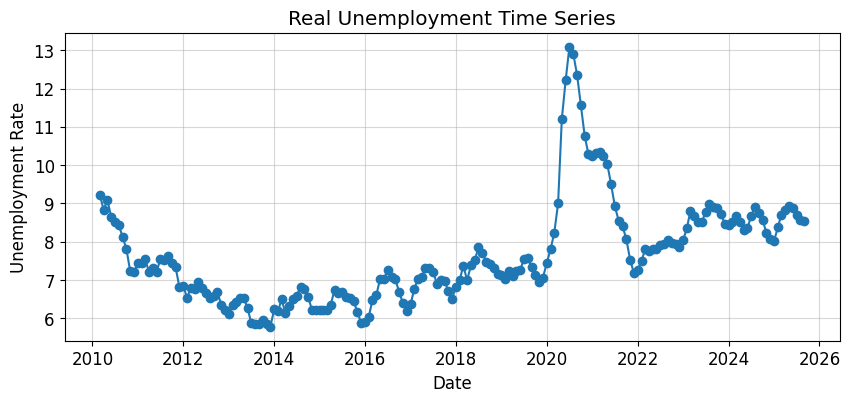

In [2]:
df = pd.read_excel(file_path, header=None)

# Seleccionar solo las filas y columnas de interés
df = df.iloc[4:191, 0:2]
df.reset_index(drop=True, inplace=True)

# Renombrar columnas
df.columns = ["Date", "Value"]

# Convertir a datetime y eliminar fechas inválidas
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])

# Convertir valores a numéricos y eliminar posibles NaN
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna(subset=["Value"])

# Configurar la columna Date como índice
df.set_index("Date", inplace=True)

# Inferir frecuencia temporal (si es mensual, trimestral, etc.)
df.index.freq = pd.infer_freq(df.index)

# Extraer la serie para modelado
X = df["Value"]

# Visualizar la serie
plt.figure(figsize=(10, 4))
plt.plot(X, marker='o', linestyle='-')
plt.title("Real Unemployment Time Series")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate")
plt.grid(True)
plt.show()


In [3]:
df_adf  = table_adf(X, autolag="AIC")
df_kpss = table_kpss(X, regression='c', nlags='auto')

print("\n=== Augmented Dickey-Fuller Test (ADF) ===")
display(df_adf)

print("\n=== KPSS Test ===")
display(df_kpss)


=== Augmented Dickey-Fuller Test (ADF) ===


,Statistic,p-value,Lags used,N obs,Crit (1%),Crit (5%),Crit (10%)
0,-2.269538,0.181981,10,176,-3.468062,-2.878106,-2.575602



=== KPSS Test ===


,Statistic,p-value,Lags used,Crit (10%),Crit (5%),Crit (2.5%),Crit (1%)
0,0.828083,0.01,9,0.347,0.463,0.574,0.739


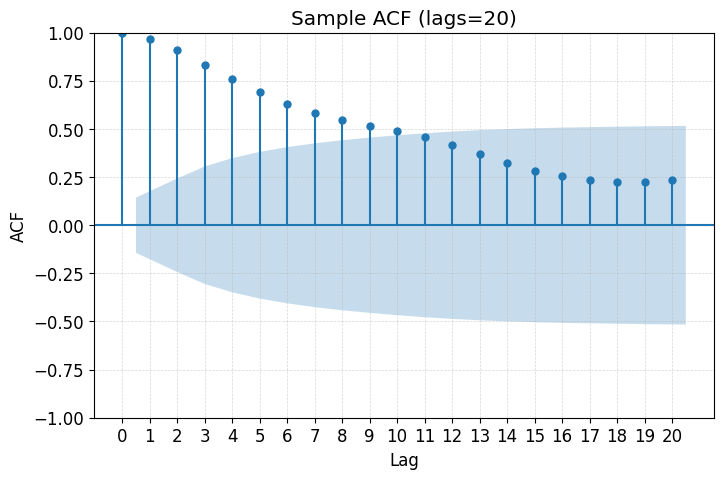

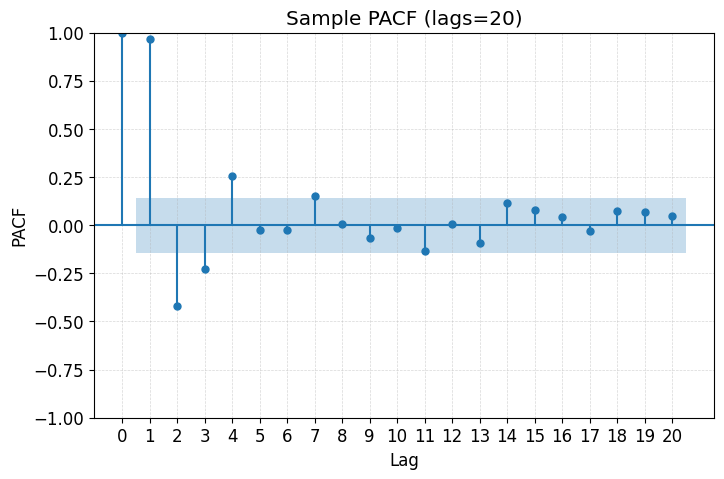

In [4]:
plot_acf_sample(X, lags=20)
plot_pacf_sample(X, lags=20)

In [5]:
df_models = arma_model_selection(X)
print(df_models)

c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


    p  q         AIC         BIC      LogLik
0   1  2   12.548189   28.703732   -1.274095
1   2  2   13.007287   32.393939   -0.503643
2   1  3   13.484555   32.871207   -0.742277
3   3  2   13.825379   36.443139    0.087310
4   3  3   15.523137   41.372006    0.238431
5   2  3   16.481157   39.098917   -1.240578
6   3  1   33.991729   53.378381  -10.995864
7   3  0   43.899549   60.055092  -16.949774
8   2  1   46.466820   62.622364  -18.233410
9   2  0   46.597142   59.521576  -19.298571
10  1  1   71.242653   84.167087  -31.621326
11  1  0  103.603497  113.296823  -48.801749
12  0  3  169.717280  185.872823  -79.858640
13  0  2  267.086032  280.010467 -129.543016
14  0  1  441.484259  451.177585 -217.742129


c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
print("\n=== Top models by AIC ===")
display(df_models.nsmallest(5, "AIC"))

print("\n=== Top models by BIC ===")
display(df_models.nsmallest(5, "BIC"))


=== Top models by AIC ===


,p,q,AIC,BIC,LogLik
0,1,2,12.548189,28.703732,-1.274095
1,2,2,13.007287,32.393939,-0.503643
2,1,3,13.484555,32.871207,-0.742277
3,3,2,13.825379,36.443139,0.087310
4,3,3,15.523137,41.372006,0.238431



=== Top models by BIC ===


,p,q,AIC,BIC,LogLik
0,1,2,12.548189,28.703732,-1.274095
1,2,2,13.007287,32.393939,-0.503643
2,1,3,13.484555,32.871207,-0.742277
3,3,2,13.825379,36.443139,0.087310
5,2,3,16.481157,39.098917,-1.240578


In [7]:
best_model = ARIMA(X, order=(1,0,2)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  187
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  -1.274
Date:                Wed, 10 Dec 2025   AIC                             12.548
Time:                        06:34:34   BIC                             28.704
Sample:                    03-01-2010   HQIC                            19.094
                         - 09-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8131      0.540     14.456      0.000       6.754       8.872
ar.L1          0.9203      0.032     29.185      0.000       0.858       0.982
ma.L1          0.6327      0.058     10.891      0.0

In [8]:
significant_params(best_model, alpha=0.05)

Significant at 5.0% level:
            coef   std_err         pvalue
const   7.813131  0.540482   2.302793e-47
ar.L1   0.920294  0.031533  3.018513e-187
ma.L1   0.632699  0.058094   1.272246e-27
ma.L2   0.636601  0.070111   1.087106e-19
sigma2  0.057914  0.003171   1.699084e-74

Not significant at 5.0% level:
Empty DataFrame
Columns: [coef, std_err, pvalue]
Index: []


In [9]:
X_train, y_test = X[:169], X[169:]
model = ARIMA(X_train, order=(1,0,2)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  169
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  -6.112
Date:                Wed, 10 Dec 2025   AIC                             22.223
Time:                        06:34:34   BIC                             37.873
Sample:                    03-01-2010   HQIC                            28.574
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7522      0.588     13.193      0.000       6.600       8.904
ar.L1          0.9216      0.034     27.475      0.000       0.856       0.987
ma.L1          0.6168      0.064      9.674      0.0

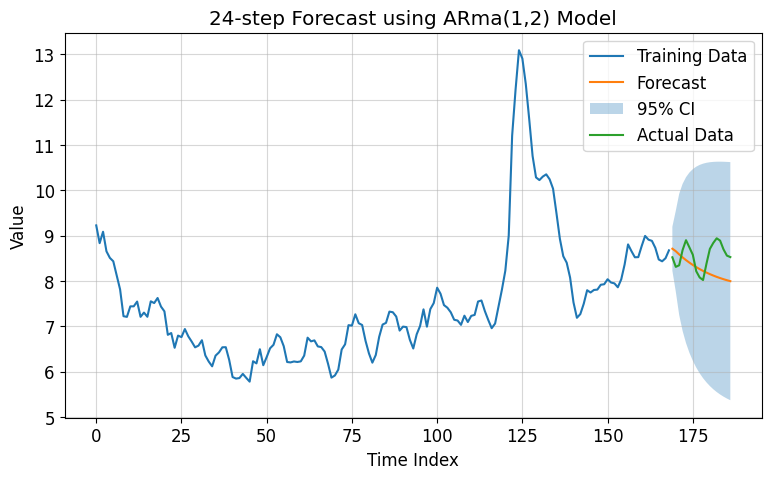

In [17]:
pred, ci = arma_forecast_plot2(model, X_train, y_test, steps=18,
                              title='24-step Forecast using ARma(1,2) Model',)

In [12]:
rmse_train, rmse_test = calculate_rmse(model, X_train, y_test)

RMSE (Training): 0.2731115933775487
RMSE (Test): 0.4689852704931622


=== Residuals Statistics ===
Mean: -0.0003
Standard Deviation: 0.2731
Minimum: -0.4662, Maximum: 1.8035


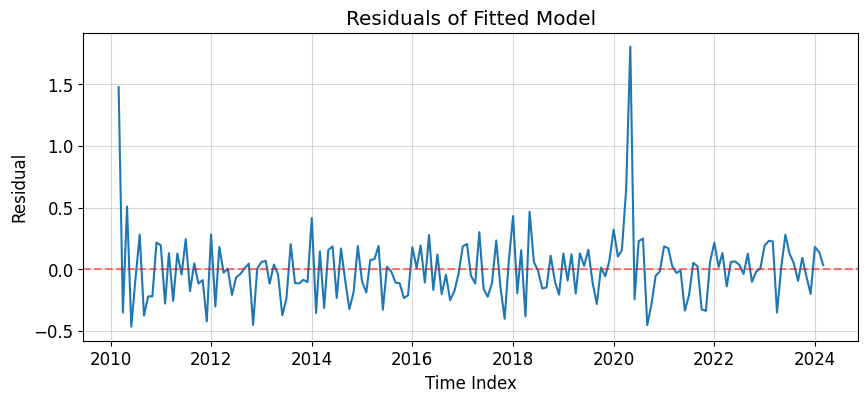

In [13]:
residuals = model.resid
residual_stats = plot_residuals(model.resid)

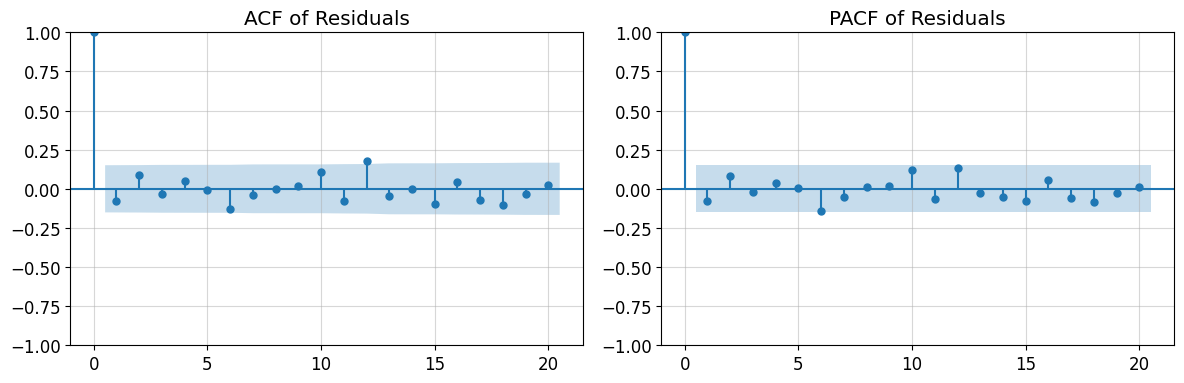

In [14]:
plot_acf_pacf_residuals(model.resid, lags=20)

In [15]:
lb_test = acorr_ljungbox(residuals, lags=[10, 15, 20], return_df=True)

print("=== Ljung-Box Test for Residuals ===")
print(lb_test)


=== Ljung-Box Test for Residuals ===
      lb_stat  lb_pvalue
10   8.193903   0.609903
15  17.035157   0.316767
20  20.745164   0.412266


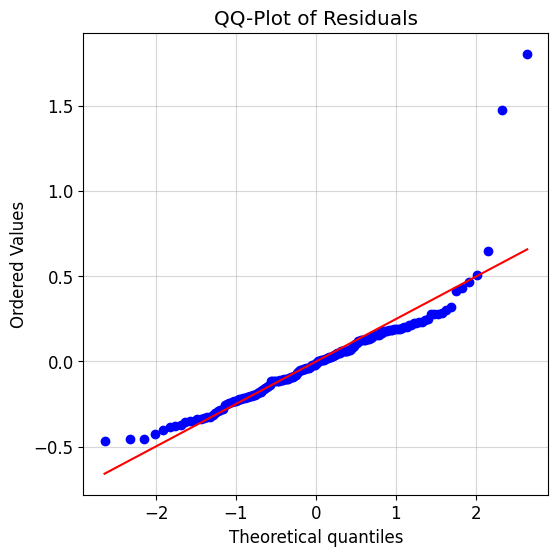

Shapiro-Wilk Test:
Statistic: 0.8178, p-value: 0.0000

Jarque-Bera Test:
Statistic: 1616.2887, p-value: 0.0000


In [16]:
normality_results = residuals_normality_test(model.resid)